11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

Training baseline...
Epoch 1/12
375/375 - 5s - 12ms/step - accuracy: 0.9125 - loss: 0.3077 - val_accuracy: 0.9578 - val_loss: 0.1471
Epoch 2/12
375/375 - 1s - 3ms/step - accuracy: 0.9649 - loss: 0.1190 - val_accuracy: 0.9660 - val_loss: 0.1133
Epoch 3/12
375/375 - 1s - 3ms/step - accuracy: 0.9778 - loss: 0.0758 - val_accuracy: 0.9691 - val_loss: 0.0990
Epoch 4/12
375/375 - 1s - 3ms/step - accuracy: 0.9852 - loss: 0.0530 - val_accuracy: 0.9714 - val_loss: 0.0949
Epoch 5/12
375/375 - 1s - 4ms/step - accuracy: 0.9890 - loss: 0.0390 - val_accuracy: 0.9738 - val_loss: 0.0913
Epoch 6/12
375/375 - 1s - 4ms/step - accuracy: 0.9917 - loss: 0.0294 - val_accuracy: 0.9723 - val_loss: 0.1010
Epoch 7/12
375/375 - 1s - 3ms/step - accuracy: 0.9940 - loss: 0.0220 - val_accuracy: 0.9718 - val_loss: 0.1078
Epoch 8/12
375/375 - 1s - 3ms/step - accuracy: 0.9952 - loss: 0.0168 - val_accuracy: 0.9743 - val_loss: 0.1041
Epoch 9/12
375/375 - 1s - 3ms/step - a

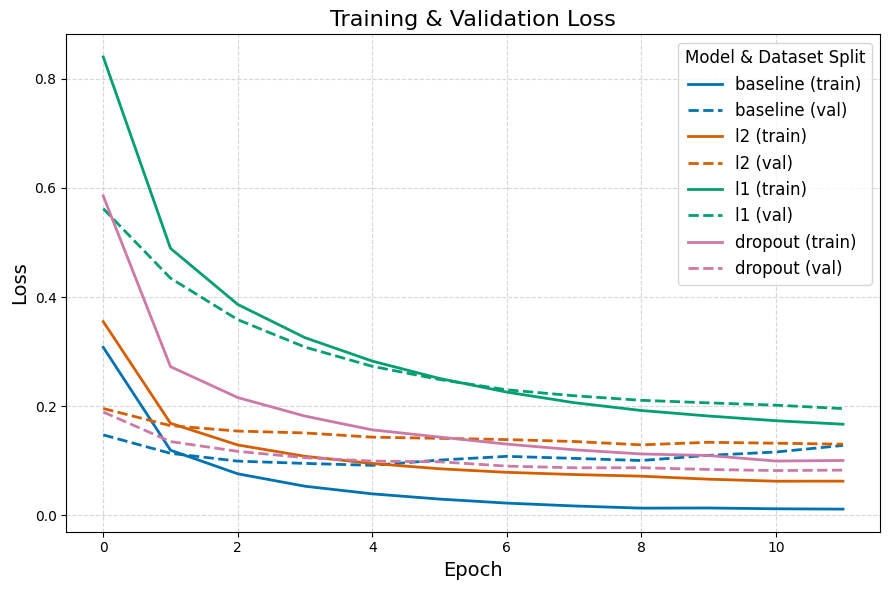

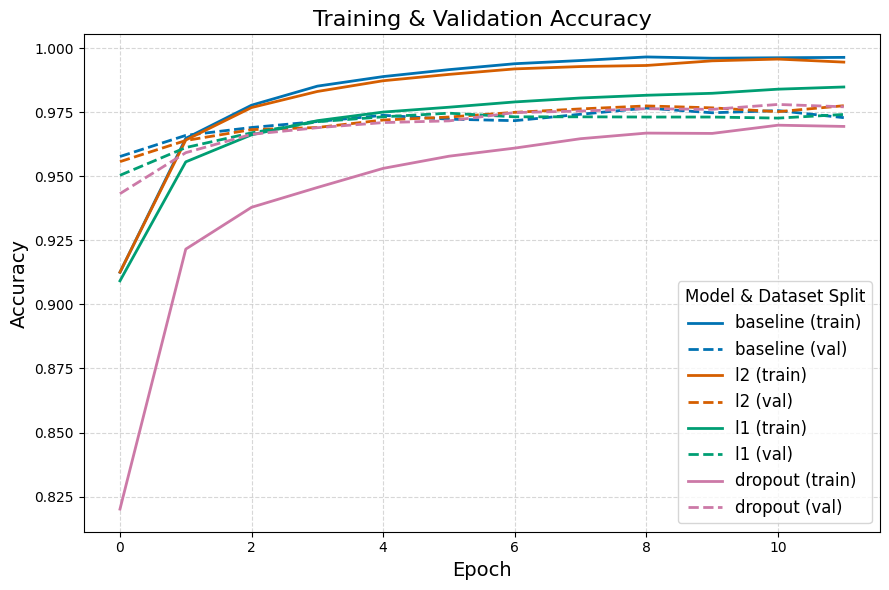


Evaluating baseline...

Evaluating l2...

Evaluating l1...

Evaluating dropout...


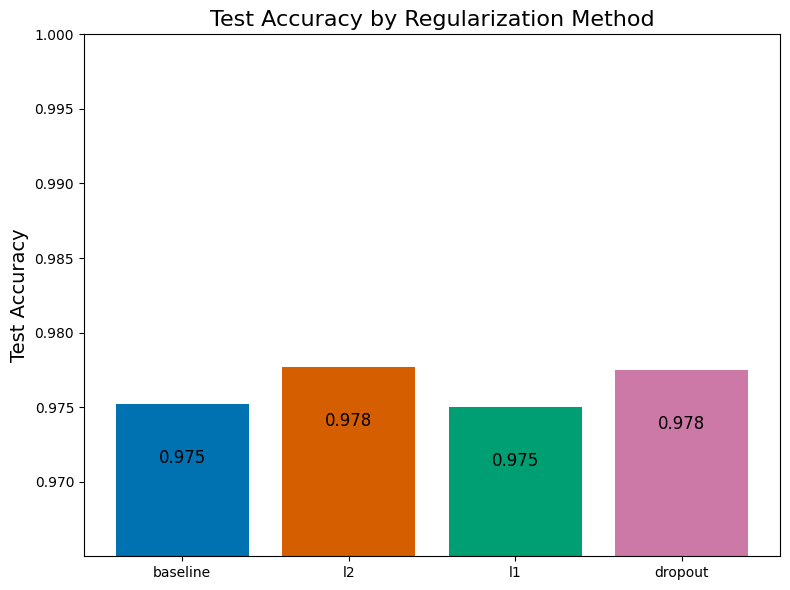

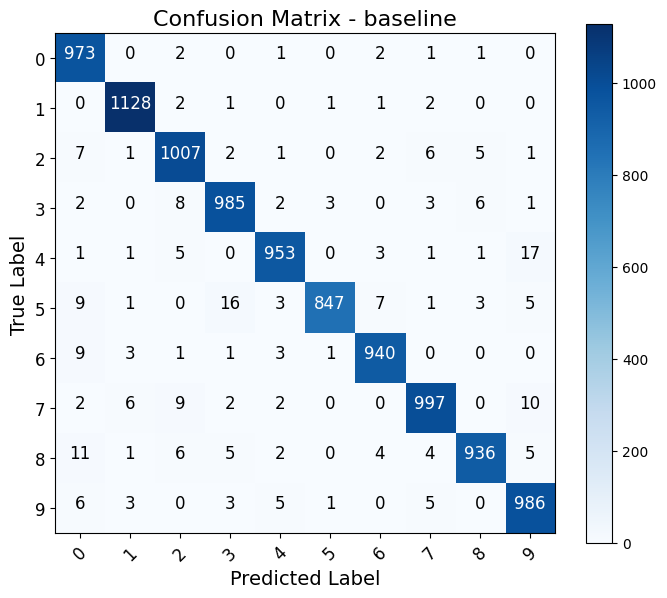

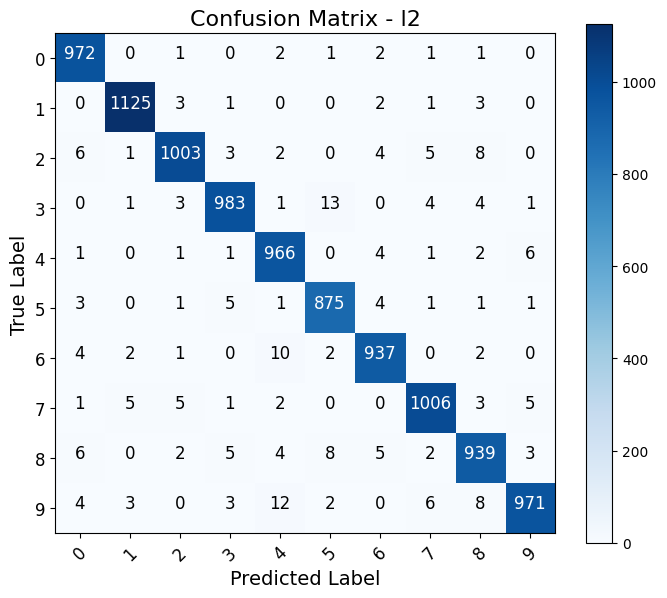

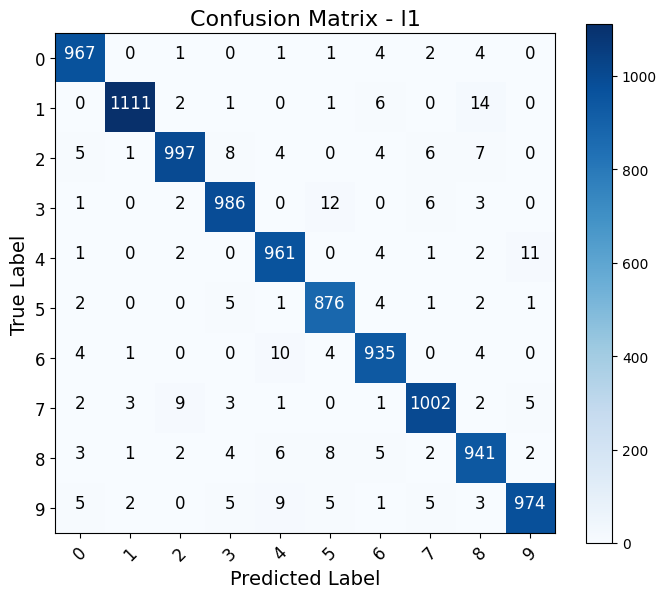

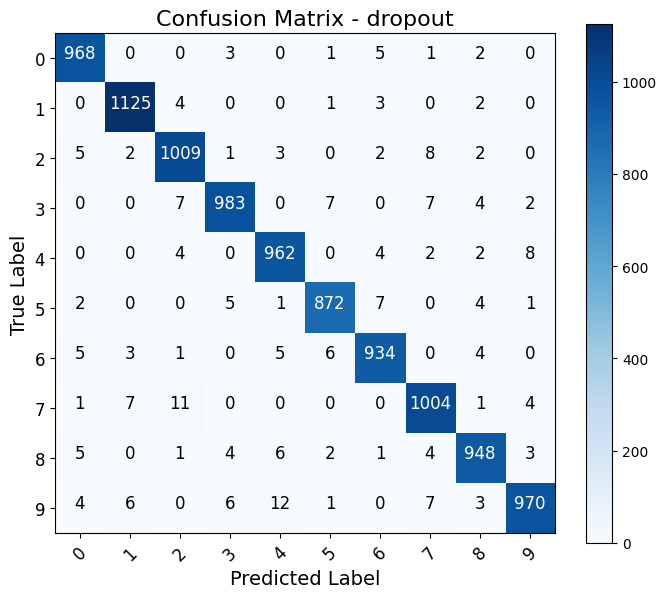


=== METRIC SUMMARY (Macro F1, Weighted F1) ===

BASELINE   | Macro F1 = 0.9750 | Weighted F1 = 0.9752
L2         | Macro F1 = 0.9775 | Weighted F1 = 0.9777
L1         | Macro F1 = 0.9748 | Weighted F1 = 0.9750
DROPOUT    | Macro F1 = 0.9774 | Weighted F1 = 0.9775


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import pandas as pd

# -------------------------------------------------------------------
# 0. Reproducibility
# -------------------------------------------------------------------
np.random.seed(42)
tf.random.set_seed(42)

# -------------------------------------------------------------------
# 1. Load & preprocess MNIST
# -------------------------------------------------------------------
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

x_train = x_train.reshape((x_train.shape[0], -1))
x_test = x_test.reshape((x_test.shape[0], -1))

num_classes = 10
y_train_cat = to_categorical(y_train, num_classes)
y_test_cat = to_categorical(y_test, num_classes)
input_dim = x_train.shape[1]

# -------------------------------------------------------------------
# 2. Model builders
# -------------------------------------------------------------------
def build_baseline_model():
    model = models.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(256, activation="relu"),
        layers.Dense(128, activation="relu"),
        layers.Dense(num_classes, activation="softmax")
    ])
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    return model

def build_l2_model(l2_lambda=1e-4):
    model = models.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(256, activation="relu", kernel_regularizer=regularizers.l2(l2_lambda)),
        layers.Dense(128, activation="relu", kernel_regularizer=regularizers.l2(l2_lambda)),
        layers.Dense(num_classes, activation="softmax")
    ])
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    return model

def build_l1_model(l1_lambda=1e-4):
    model = models.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(256, activation="relu", kernel_regularizer=regularizers.l1(l1_lambda)),
        layers.Dense(128, activation="relu", kernel_regularizer=regularizers.l1(l1_lambda)),
        layers.Dense(num_classes, activation="softmax")
    ])
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    return model

def build_dropout_model(drop_rate=0.5):
    model = models.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(256, activation="relu"),
        layers.Dropout(drop_rate),
        layers.Dense(128, activation="relu"),
        layers.Dropout(drop_rate),
        layers.Dense(num_classes, activation="softmax")
    ])
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    return model

# -------------------------------------------------------------------
# 3. Train all models
# -------------------------------------------------------------------
EPOCHS = 12
BATCH_SIZE = 128
VAL_SPLIT = 0.2

models_dict = {
    "baseline": build_baseline_model(),
    "l2": build_l2_model(),
    "l1": build_l1_model(),
    "dropout": build_dropout_model()
}

histories = {}
for name, model in models_dict.items():
    print(f"\nTraining {name}...")
    hist = model.fit(
        x_train, y_train_cat,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        validation_split=VAL_SPLIT,
        verbose=2
    )
    histories[name] = hist

# -------------------------------------------------------------------
# 4. Accessible colour-blind-friendly palette
# -------------------------------------------------------------------
COLORS = {
    "baseline": "#0072B2",
    "l2": "#D55E00",
    "l1": "#009E73",
    "dropout": "#CC79A7"
}

# -------------------------------------------------------------------
# 5. Plot learning curves (loss + accuracy)
# -------------------------------------------------------------------
def plot_metric(histories, metric="loss"):
    plt.figure(figsize=(9,6))
    for name, hist in histories.items():
        plt.plot(hist.history[metric], label=f"{name} (train)", color=COLORS[name], linewidth=2)
        plt.plot(hist.history[f"val_{metric}"], label=f"{name} (val)", linestyle="--", color=COLORS[name], linewidth=2)
    plt.xlabel("Epoch", fontsize=14)
    plt.ylabel(metric.capitalize(), fontsize=14)
    plt.title(f"Training & Validation {metric.capitalize()}", fontsize=16)
    plt.grid(True, linestyle="--", alpha=0.5)
    legend = plt.legend(title="Model & Dataset Split", fontsize=12, title_fontsize=12)
    plt.tight_layout()
    plt.show()

plot_metric(histories, metric="loss")
plot_metric(histories, metric="accuracy")

# -------------------------------------------------------------------
# 6. Evaluate all models, collect metrics
# -------------------------------------------------------------------
test_results = {}
for name, model in models_dict.items():
    print(f"\nEvaluating {name}...")
    loss, acc = model.evaluate(x_test, y_test_cat, verbose=0)
    y_pred_probs = model.predict(x_test, verbose=0)
    y_pred = np.argmax(y_pred_probs, axis=1)

    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)

    test_results[name] = {
        "loss": loss,
        "accuracy": acc,
        "y_pred": y_pred,
        "report": report
    }

# -------------------------------------------------------------------
# 7. Plot test accuracy bar chart
# -------------------------------------------------------------------
def plot_test_accuracy_bar(test_results):
    names = list(test_results.keys())
    accuracies = [test_results[n]["accuracy"] for n in names]

    plt.figure(figsize=(8,6))
    bars = plt.bar(names, accuracies, color=[COLORS[n] for n in names])
    plt.ylabel("Test Accuracy", fontsize=14)
    plt.title("Test Accuracy by Regularization Method", fontsize=16)
    plt.ylim(min(accuracies)-0.01, 1.0)

    for bar, value in zip(bars, accuracies):
        plt.text(bar.get_x()+bar.get_width()/2, value-0.003, f"{value:.3f}",
                 ha="center", va="top", fontsize=12)

    plt.tight_layout()
    plt.show()

plot_test_accuracy_bar(test_results)

# -------------------------------------------------------------------
# 8. Confusion matrix plotting
# -------------------------------------------------------------------
def plot_confusion_matrix(cm, classes, title="Confusion Matrix", cmap=plt.cm.Blues):
    plt.figure(figsize=(7,6))
    plt.imshow(cm, interpolation="nearest", cmap=cmap)
    plt.title(title, fontsize=16)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=12)
    plt.yticks(tick_marks, classes, fontsize=12)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i,j],'d'),
                 horizontalalignment="center",
                 color="white" if cm[i,j] > thresh else "black",
                 fontsize=12)

    plt.ylabel("True Label", fontsize=14)
    plt.xlabel("Predicted Label", fontsize=14)
    plt.tight_layout()
    plt.show()

class_names = [str(i) for i in range(num_classes)]

for name, res in test_results.items():
    cm = confusion_matrix(y_test, res["y_pred"])
    plot_confusion_matrix(cm, class_names, title=f"Confusion Matrix - {name}")

# -------------------------------------------------------------------
# 9. Print F1, Precision, Recall summaries
# -------------------------------------------------------------------
print("\n=== METRIC SUMMARY (Macro F1, Weighted F1) ===\n")
for name, res in test_results.items():
    report = res["report"]
    macro_f1 = report["macro avg"]["f1-score"]
    weighted_f1 = report["weighted avg"]["f1-score"]
    print(f"{name.upper():10s} | Macro F1 = {macro_f1:.4f} | Weighted F1 = {weighted_f1:.4f}")

